In [2]:
import numpy as np
import pandas as pd
import os
import warnings
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import gamma
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
# import optperfprofpy

import sys 
sys.path.append('..')
from utils.demand_pkg import *
import matplotlib.pyplot as plt
from utils.algorithms import get_opt, get_EQ, get_end2end_iid, get_end2end, get_normal_basestock, get_gamma_basestock, get_normal_basestock2

import tensorflow as tf

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [759]:
# o0 = pd.read_csv('../data/1320_feature/features_v11.csv', parse_dates=['create_tm','complete_dt','dt','next_complete_dt'],
#                  usecols=lambda col: col not in ['d_vlt'])
with open('../data/1320_feature/df_e2e.pkl', 'rb') as fp:
    o0 = pickle.load(fp)
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)

In [760]:
o0.shape

(126129, 156)

In [761]:
# o_num = o2.loc[:, feature_list+LABEL]
# for i in range(2, o_num.shape[1]):
#     plt.figure();
#     ax = sns.distplot(o_num.iloc[:,i]);
#     plt.savefig('../figures/vlm/%i.png' %i);
#     plt.close();

In [762]:
IDX = ['item_sku_id','sku_id']

CAT_FEA = [
#     'item_first_cate_cd', 'item_second_cate_cd', 
    'item_third_cate_cd', 
    'int_org_num', 
#     'brand_code', 
#     'create_day_of_week'
    ]

VLT_FEA = [
#            'review_period', 
    'uprc', 'contract_stk_prc', 
    'wt', 'width', 'height', 'calc_volume', 'len',
    'vlt_count', 'vlt_sum', 'vlt_min', 'vlt_max', 'vlt_mean', 'vlt_std',
    'qtty_sum', 'qtty_min', 'qtty_max', 'qtty_mean', 'qtty_std', 
    'amount_sum', 'amount_min', 'amount_max', 'amount_mean', 'amount_std', 
    'vlt_count_6mo', 'vlt_sum_6mo', 'vlt_min_6mo', 'vlt_max_6mo', 'vlt_mean_6mo', 'vlt_std_6mo',
    'vendor_vlt_count', 'vendor_vlt_sum', 'vendor_vlt_min', 'vendor_vlt_max', 'vendor_vlt_mean', 'vendor_vlt_std', 
    'vendor_vlt_count_6mo', 'vendor_vlt_sum_6mo', 'vendor_vlt_min_6mo', 
    'vendor_vlt_max_6mo', 'vendor_vlt_mean_6mo', 'vendor_vlt_std_6mo', 
    'vendor_qtty_sum', 'vendor_qtty_min', 'vendor_qtty_max', 
    'vendor_qtty_mean', 'vendor_qtty_std', 'vendor_amount_sum',
    'vendor_amount_min', 'vendor_amount_max', 'vendor_amount_mean'
        ]

SF_FEA = [
        'q_7', 'q_14', 'q_28', 'q_56', 'q_112', 
        'mean_3', 'mean_7', 'mean_14', 'mean_28', 'mean_56', 'mean_112', 
        'diff_140_mean', 'mean_140_decay', 'median_140', 'min_140', 'max_140', 'std_140', 
        'diff_60_mean', 'mean_60_decay', 'median_60', 'min_60', 'max_60', 'std_60', 
        'diff_30_mean', 'mean_30_decay', 'median_30', 'min_30', 'max_30', 'std_30', 
        'diff_14_mean', 'mean_14_decay', 'median_14', 'min_14', 'max_14', 'std_14',
        'diff_7_mean', 'mean_7_decay', 'median_7', 'min_7', 'max_7', 'std_7',
        'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
        'has_sales_days_in_last_140', 'last_has_sales_day_in_last_140',
        'first_has_sales_day_in_last_140', 'has_sales_days_in_last_60',
        'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
        'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
        'first_has_sales_day_in_last_30', 'has_sales_days_in_last_14',
        'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
        'has_sales_days_in_last_7', 'last_has_sales_day_in_last_7', 'first_has_sales_day_in_last_7'
            ]
   
MORE_FEA =[
           'review_period', 
           'normal', 
           'gamma', 
            'eq'
            ]

IS_FEA = [
           'initial_stock', 
#            'IS_over_mean_56'
        ]
    
# LABEL = ['target_decision']  
    
CAT_FEA_HOT = ['item_third_cate_cd_1591',
             'item_third_cate_cd_2677',
             'item_third_cate_cd_5022',
             'item_third_cate_cd_5024',
             'int_org_num_3',
             'int_org_num_4',
             'int_org_num_5',
             'int_org_num_6',
             'int_org_num_9',
             'int_org_num_10',
             'int_org_num_316',
             'int_org_num_772']
TO_SCALE = [
            # 'label_sf'
            ]
SEQ2SEQ = ['Enc_X', 'Enc_y', 'Dec_X', 'Dec_y']

LABEL = ['demand_RV']    
LABEL_vlt = ['vlt_actual']    
LABEL_sf = ['label_sf'] 

In [763]:
SCALE_FEA =  VLT_FEA + SF_FEA + MORE_FEA + IS_FEA + CAT_FEA_HOT + TO_SCALE + LABEL_vlt + LABEL_sf
CUT_FEA = VLT_FEA + SF_FEA + MORE_FEA
MODEL_FEA = VLT_FEA + SF_FEA + MORE_FEA + IS_FEA + CAT_FEA_HOT

In [818]:
sku_set = o0.sku_id.unique()
sku_train, sku_test = train_test_split(sku_set, random_state=10, train_size=0.85, test_size=0.15)
# with open('../data/1320_feature/sku_buddle.pkl', 'rb') as fp:
#     sku_train, sku_test = pickle.load(fp)
df_train = o0[(o0['sku_id'].isin(sku_train)) & (o0['create_tm'] >= dt.datetime(2018,7,25))]
df_test = o0[(o0['sku_id'].isin(sku_test)) & (o0['create_tm'] < dt.datetime(2018,7,25))]

In [819]:
# with open('../data/1320_feature/sku_buddle.pkl', 'wb') as file_pkl:
#     pickle.dump([sku_train, sku_test], file_pkl, protocol=pickle.HIGHEST_PROTOCOL)

In [820]:
df_train.shape, df_test.shape

((67041, 156), (6883, 156))

In [821]:
X_train_ns, y_train_ns, id_train = df_train[SCALE_FEA], df_train[LABEL], df_train[IDX]
X_test_ns, y_test_ns, id_test = df_test[SCALE_FEA], df_test[LABEL], df_test[IDX]

n_train, n_test = len(X_train_ns), len(X_test_ns)

In [822]:
# y_train_ns = np.log(y_train_ns+1)
# y_test_ns = np.log(y_test_ns+1)

In [823]:
print(X_train_ns.mean_7.mean(), X_test_ns.mean_7.mean())

21.53812873572036 20.224798156949838


In [824]:
X_scaler = MinMaxScaler() # For normalizing dataset
y_scaler = MinMaxScaler() # For normalizing dataset
# We want to predict Close value of stock 
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_ns), columns=X_train_ns.columns)
y_train = pd.DataFrame(y_scaler.fit_transform(y_train_ns), columns=y_train_ns.columns)
# y_train = y_train_ns

X_test = pd.DataFrame(X_scaler.transform(X_test_ns), columns=X_test_ns.columns)
y_test = pd.DataFrame(y_scaler.transform(y_test_ns), columns=y_test_ns.columns)
# y_test = y_test_ns

# pd.DataFrame(min_max_scaler.inverse_transform(y_test), columns=y_test.columns)

In [825]:
pd_scaler = pd.concat([pd.DataFrame([y_scaler.data_min_,y_scaler.scale_], columns=y_train_ns.columns),
            pd.DataFrame([X_scaler.data_min_,X_scaler.scale_], columns=X_train_ns.columns)], axis=1)
pd_scaler.to_csv('../data/1320_feature/scaler.csv', index=False)

In [826]:
pd_scaler = pd.read_csv('../data/1320_feature/scaler.csv')
pd_scaler.loc[1, 'label_sf']

0.0002870976611063295

In [827]:
X_train = X_train[MODEL_FEA]
X_test = X_test[MODEL_FEA]

In [855]:
cat_dim = len(CAT_FEA_HOT)
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim =  vlt_dim + sf_dim + oth_dim + is_dim + cat_dim

hidden_dim = [[100, 120], 160, 30]

output_dim = 1
q = 0.6


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_cat = tf.placeholder(tf.float32, shape=[None, cat_dim], name='Input_pf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')
    mean_vlt = tf.expand_dims(x_vlt[:,-17],1, name='mean_vlt')
    review_p = tf.expand_dims(x_oth[:,0],1, name='review_p')

with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim+cat_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(tf.concat([x_vlt, x_cat], axis=1), W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim+cat_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Bias_1_sf')
    l1_sf = tf.add(tf.matmul(tf.concat([x_sf, x_cat], axis=1), W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)
            
# with tf.variable_scope('Layer_1_profile'):
#     W1_pf = tf.Variable(tf.truncated_normal([cat_dim, hidden_dim[0][2]], stddev=0.001), name='Weight_1_pf')
#     b1_pf = tf.Variable(tf.zeros([hidden_dim[0][2]]), name='Bias_1_pf')
#     l1_pf = tf.add(tf.matmul(x_cat, W1_pf), b1_pf)
#     l1_pf = tf.nn.relu(l1_pf)

with tf.variable_scope('Layer_2'):
    W2 = tf.Variable(tf.truncated_normal([hidden_dim[0][0]+hidden_dim[0][1]+oth_dim, hidden_dim[1]], stddev=0.001), name='Weight_2')
    b2 = tf.Variable(tf.zeros([hidden_dim[1]]), name='Bias_3')
    l2 = tf.add(tf.matmul(tf.concat([l1_vlt, l1_sf, x_oth], axis=1), W2), b2)
    l2 = tf.nn.relu(l2)

with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1], hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_final'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2]+is_dim, 1], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([1]), name='Bias_4')
    output = tf.add(tf.matmul(tf.concat([l3, x_is], axis=1), W4), b4)
    error = y - output
#     loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )
    c_os = q*error
    c_hd = (q-1)*error
    loss = tf.reduce_mean(tf.maximum(c_os, c_hd) )
#     c_os = tf.maximum(tf.zeros([1], tf.float32), q*error)
#     c_hd = tf.multiply((1-q)*output, review_p + mean_vlt )*0.5
#     loss = tf.reduce_mean(c_os+ c_hd )    

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [856]:
epochs = 40
batch_size = 64
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("output", sess.graph)
writer.close()


train_err = sess.run(loss, feed_dict={x_vlt: X_train[VLT_FEA].values, 
                                     x_sf: X_train[SF_FEA].values, 
                                     x_oth: X_train[MORE_FEA].values, 
                                     x_cat: X_train[CAT_FEA_HOT].values, 
                                     x_is: X_train[IS_FEA].values, 
                                     y: y_train.values})
test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                     x_sf: X_test[SF_FEA].values, 
                                     x_oth: X_test[MORE_FEA].values, 
                                     x_cat: X_test[CAT_FEA_HOT].values, 
                                     x_is: X_test[IS_FEA].values, 
                                     y: y_test.values})
print(0, train_err, test_err)
for epoch in range(epochs):
    # Split data to batches
    train_err = 0
    for idx in range(0, X_train.shape[0], batch_size):
        bs = min(idx + batch_size, n_train) - idx
        batch_data = X_train.iloc[idx:bs+idx, :]
        batch_data_ns = X_train_ns.iloc[idx:bs+idx, :]
        batch_labels = y_train.iloc[idx:bs+idx, :]
        feed_dict = {x_vlt: batch_data[VLT_FEA].values, 
                     x_sf: batch_data[SF_FEA].values, 
                     x_oth: batch_data[MORE_FEA].values,
                     x_cat: batch_data[CAT_FEA_HOT].values,
                     x_is: batch_data[IS_FEA].values,
                     y: batch_labels}
        _, c_loss = sess.run([train_step, loss], feed_dict)
        train_err += c_loss*bs
    test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                         x_sf: X_test[SF_FEA].values, 
                                         x_oth: X_test[MORE_FEA].values, 
                                         x_cat: X_test[CAT_FEA_HOT].values, 
                                         x_is: X_test[IS_FEA].values, 
                                         y: y_test.values})
    print(epoch+1, train_err/n_train, test_err)

0 0.018126063 0.018642688
1 0.007763355559632357 0.006193564
2 0.005400218642574244 0.0060176137
3 0.0052814386035447735 0.005922213
4 0.00519542699889624 0.0057980707
5 0.0051069670020266475 0.005706424
6 0.0050297166708224966 0.0056030513
7 0.004952035004126942 0.0055012996
8 0.004874093139099896 0.0053911502
9 0.004806715083727204 0.005302362
10 0.004750409125429335 0.0052368655
11 0.004703293125744584 0.00516935
12 0.004659279007605788 0.0051231044
13 0.00461283779645888 0.0050522806
14 0.004582544744528293 0.005016076
15 0.004551763620604711 0.0050240606
16 0.004522769782697529 0.004932502
17 0.004490449625054758 0.004930213
18 0.004471706570263243 0.004881108
19 0.004451242184985601 0.004858709
20 0.004422012235825608 0.004833017
21 0.00439261482893558 0.004797261
22 0.00437887047355407 0.004791116
23 0.004357998662843515 0.0047782892
24 0.004335188142541549 0.004769944
25 0.004325128601198089 0.0047532506
26 0.004300329073405141 0.004736223
27 0.0042774534727064726 0.004747027
2

In [857]:
pred = sess.run(output, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                  x_sf: X_test[SF_FEA].values, 
                                  x_oth: X_test[MORE_FEA].values, 
                                  x_cat: X_test[CAT_FEA_HOT].values, 
                                  x_is: X_test[IS_FEA].values, 
                                  })

pred = pd.DataFrame(y_scaler.inverse_transform(pred), columns=['E2E_NN_pred']).fillna(0)
# pred = pd.DataFrame(np.exp(pred)-1, columns=['prediction']).fillna(0)

In [858]:
# pred_path = '../logs/torch/pred.csv'
# pred = pd.read_csv(pred_path)

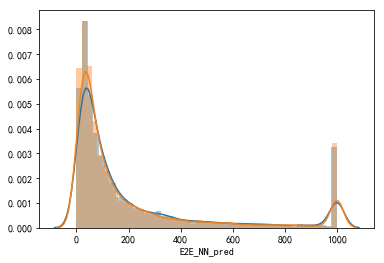

In [859]:
sns.distplot(pred['E2E_NN_pred'].clip(0,1000));
sns.distplot(y_test_ns.clip(0,1000));
# g.set(lim=(0, None))

In [882]:
gbm = lgb.LGBMRegressor(alpha=0.6, objective='quantile', max_depth = -10, num_leaves=31, learning_rate=0.05, 
                        n_estimators=500, 
                        subsample=0.7,
                        reg_sqrt = True,
                        silent=1,
                        seed=0 )

gbm.fit(X_train, y_train.values.T[0], eval_set=(X_test, y_test.values.T[0])) 

[1]	valid_0's l2: 0.00440774
[2]	valid_0's l2: 0.00432069
[3]	valid_0's l2: 0.00422873
[4]	valid_0's l2: 0.00412606
[5]	valid_0's l2: 0.00401928
[6]	valid_0's l2: 0.00390461
[7]	valid_0's l2: 0.00381209
[8]	valid_0's l2: 0.00369936
[9]	valid_0's l2: 0.00357985
[10]	valid_0's l2: 0.00345613
[11]	valid_0's l2: 0.00333933
[12]	valid_0's l2: 0.00322581
[13]	valid_0's l2: 0.00310268
[14]	valid_0's l2: 0.00299188
[15]	valid_0's l2: 0.00287469
[16]	valid_0's l2: 0.00275961
[17]	valid_0's l2: 0.00264412
[18]	valid_0's l2: 0.00256705
[19]	valid_0's l2: 0.00245651
[20]	valid_0's l2: 0.00235852
[21]	valid_0's l2: 0.00225599
[22]	valid_0's l2: 0.00216338
[23]	valid_0's l2: 0.00208513
[24]	valid_0's l2: 0.00199757
[25]	valid_0's l2: 0.001912
[26]	valid_0's l2: 0.00182899
[27]	valid_0's l2: 0.0017564
[28]	valid_0's l2: 0.00169533
[29]	valid_0's l2: 0.00162832
[30]	valid_0's l2: 0.00156816
[31]	valid_0's l2: 0.00151611
[32]	valid_0's l2: 0.00146171
[33]	valid_0's l2: 0.00141282
[34]	valid_0's l2: 0.0

[266]	valid_0's l2: 0.000556124
[267]	valid_0's l2: 0.000556261
[268]	valid_0's l2: 0.000555914
[269]	valid_0's l2: 0.0005549
[270]	valid_0's l2: 0.000554792
[271]	valid_0's l2: 0.000555505
[272]	valid_0's l2: 0.00055503
[273]	valid_0's l2: 0.000555565
[274]	valid_0's l2: 0.00055652
[275]	valid_0's l2: 0.000556209
[276]	valid_0's l2: 0.000556281
[277]	valid_0's l2: 0.00055603
[278]	valid_0's l2: 0.000555905
[279]	valid_0's l2: 0.000556379
[280]	valid_0's l2: 0.00055629
[281]	valid_0's l2: 0.0005561
[282]	valid_0's l2: 0.000555693
[283]	valid_0's l2: 0.000555395
[284]	valid_0's l2: 0.000555276
[285]	valid_0's l2: 0.000554638
[286]	valid_0's l2: 0.000554643
[287]	valid_0's l2: 0.00055462
[288]	valid_0's l2: 0.000553186
[289]	valid_0's l2: 0.000553287
[290]	valid_0's l2: 0.000553284
[291]	valid_0's l2: 0.000553304
[292]	valid_0's l2: 0.000553433
[293]	valid_0's l2: 0.00055325
[294]	valid_0's l2: 0.000553262
[295]	valid_0's l2: 0.00055304
[296]	valid_0's l2: 0.00055293
[297]	valid_0's l2: 

LGBMRegressor(alpha=0.6, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, learning_rate=0.05, max_depth=-10,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=31, objective='quantile',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, reg_sqrt=True,
       seed=0, silent=1, subsample=0.7, subsample_for_bin=200000,
       subsample_freq=0)

In [883]:
gbm_pred=gbm.predict(X_test) 

gbm_pred = pd.DataFrame(y_scaler.inverse_transform(gbm_pred.reshape(-1, 1)), columns=['E2E_GBM_pred']).fillna(0)
# gbm_pred = pd.DataFrame(np.exp(gbm_pred)-1, columns=['prediction']).fillna(0)

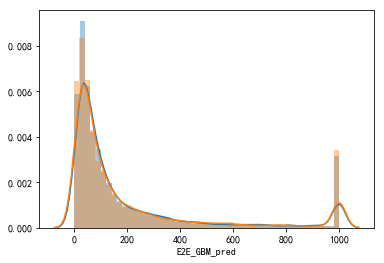

In [884]:
sns.distplot(gbm_pred['E2E_GBM_pred'].clip(0,1000));
sns.distplot(y_test_ns.clip(0,1000));

In [885]:
h = 1
b = 9

In [886]:
o4 = df_test.copy()
o4.reset_index(drop=True, inplace=True)

In [887]:
o4['demand_RV_list'] = o4.apply(lambda x: df_sl.loc[x['item_sku_id'], \
                                            x['create_tm'].date():x['next_complete_dt'].date()].values\
                            if x['item_sku_id'] in df_sl.index else [], axis=1)

o4['demand_RV_list_acm'] = o4['demand_RV_list'].apply(lambda x: np.cumsum(x))

In [888]:
list_c = ['SKU_DC', 'create_tm', 'OPT', 'E2E_NN', 'E2E_GBM', 'EQ',  'Normal', 'Gamma', 'Hist', 
          'Ave_sales','Std_sales', 
#           'Ave_review', 'Std_review'
         ]
numberOfRows = len(o4)

df_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

In [889]:
df_cost['SKU_DC']=df_holding['SKU_DC']=df_back['SKU_DC']=df_stockout['SKU_DC']=df_turnover['SKU_DC']=o4['item_sku_id'].values
df_cost['create_tm']=df_holding['create_tm']=df_back['create_tm']=df_stockout['create_tm']=df_turnover['create_tm']=o4['create_tm'].values
df_cost['Ave_sales']=df_holding['Ave_sales']=df_back['Ave_sales']=df_stockout['Ave_sales']=df_turnover['Ave_sales']=o4['mean_112'].values
df_cost['Std_sales']=df_holding['Std_sales']=df_back['Std_sales']=df_stockout['Std_sales']=df_turnover['Std_sales']=o4['std_140'].values

In [ ]:
def get_inv(x, name):
    inv1, inv2 = [], []
 
    for t in range(len(x['demand_RV_list_acm'])):
        if t < np.ceil(x['vlt_actual']):
            inv1.append(x['initial_stock']-x['demand_RV_list_acm'][t])
            continue
        else:
#             if inv[-1] <= 0:
#                 inv.append(-x['demand_RV_list'][t])
#             else:
#                 inv.append(inv[-1] - x['demand_RV_list'][t])
            inv_ = x[name]+x['initial_stock']-x['demand_RV_list_acm'][t]
            inv1.append(inv_)
            inv2.append(inv_)
    return [inv1, inv2]

Z90 = 1.96
o4['OPT_inv_f'], o4['OPT_inv'] = zip(*o4.apply(lambda x: get_inv(x, 'target_decision'), axis=1))

o4['EQ_pred'] = pd.read_csv('EQ_replen_with_IS.csv')
o4['EQ_replen'] = (o4['EQ_pred'] - o4['initial_stock']).clip(0)
o4['EQ_inv_f'], o4['EQ_inv'] = zip(*o4.apply(get_inv, name='EQ_replen', axis=1))

o4['Normal_pred'] = o4.apply(lambda x: int(x['mean_112']*(x['review_period']+x['vendor_vlt_mean'])
                                       +Z90*np.sqrt((x['review_period']+x['vendor_vlt_mean'])*x['std_140']**2
                                                    + x['std_140']**2 * x['vlt_std'])), axis=1)
o4['Normal_replen'] = (o4['Normal_pred'] - o4['initial_stock']).clip(0)
o4['Normal_inv_f'], o4['Normal_inv'] = zip(*o4.apply(get_inv, name='Normal_replen',  axis=1))

def gamma_base(x):
    mean = x['mean_112']
    var = x['std_140']**2
    theta = var/(mean+1e-4)
    k = mean/(theta+1e-4)
    k_sum = int(x['review_period']+x['vendor_vlt_mean'])*k
    gamma_stock = gamma.ppf(0.9, a=k_sum, scale = theta)
    if(np.isnan(gamma_stock)):
        return 0
    else:
        return int(gamma_stock)

o4['Gamma_pred'] = o4.apply(gamma_base, axis=1)
o4['Gamma_replen'] = (o4['Gamma_pred'] - o4['initial_stock']).clip(0)
o4['Gamma_inv_f'],o4['Gamma_inv'] = zip(*o4.apply(get_inv, name='Gamma_replen', axis=1))

o4['Hist_inv_f'], o4['Hist_inv'] = zip(*o4.apply(get_inv, name='actual_pur_qtty', axis=1))

In [ ]:
# o4['demand_EQ_list'] = o4.apply(lambda x: df_sl.iloc[:,360:].loc[x['item_sku_id'], \
#                                             :x['create_tm'].date()].values\
#                             if x['item_sku_id'] in df_sl.index else [], axis=1)
# o4['EQ_replen_with_IS'] = o4.apply(lambda x: np.percentile(
#                             [np.sum(x['demand_EQ_list'][i:i+int(x['review_period']+x['vendor_vlt_mean'])])
#                                      for i in range(int(len(x['demand_EQ_list'])-x['review_period']-x['vendor_vlt_mean']))
#                             ], 90), axis=1)
# o4['EQ_replen_with_IS'] = o4['EQ_replen_with_IS'] - o4['initial_stock_overall']
# o4['EQ_replen_with_IS'].to_csv('EQ_replen_with_IS.csv', index=False)
# o4['EQ_replen_with_IS'] = pd.read_csv('EQ_replen_with_IS.csv')


In [ ]:
o4['E2E_GBM_replen'] = (gbm_pred['E2E_GBM_pred'] - o4['initial_stock']).clip(0)
# o4['gbm_pred'] = gbm_pred['prediction'].clip(0)
o4['E2E_GBM_inv_f'], o4['E2E_GBM_inv'] = zip(*o4.apply(get_inv, name='E2E_GBM_replen',  axis=1))

o4['E2E_NN_replen'] = (pred['E2E_NN_pred'] - o4['initial_stock']).clip(0)
# o4['nn_pred'] = pred['prediction'].clip(0)
o4['E2E_NN_inv_f'], o4['E2E_NN_inv'] = zip(*o4.apply(get_inv, name='E2E_NN_replen', axis=1))

In [ ]:
h,b = 1, 9
str_list = ['OPT', 'E2E_NN', 'E2E_GBM', 'EQ', 'Normal', 'Gamma', 'Hist']
for str1 in str_list:
    str2 = str1 + '_inv'
    df_holding[str1] = o4[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df_back[str1] = o4[str2].apply(lambda x: b * (0 if  x==[] else max(0, -x[-1])))
    df_stockout[str1] = o4[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df_turnover[str1] = o4.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_112']
                                  if np.mean(x['mean_112']) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df_cost[str1] = df_holding[str1] + df_back[str1]

In [ ]:
# h,b = 1,9
# str_list = ['OPT', 'E2E_NN', 'E2E_GBM', 'EQ', 'Normal', 'Gamma', 'Hist']
# o4['OPT_replen'] = o4['target_decision']
# o4['Hist_replen'] = o4['actual_pur_qtty']
# for str1 in str_list:
#     str_r = str1 + '_replen'
#     str2 = str1 + '_inv'
#     df_holding[str1] = (o4[str_r] - o4['target_decision']).clip(0) * h
#     df_back[str1] = (o4['target_decision'] - o4[str_r]).clip(0) * b
#     df_stockout[str1] = o4[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
#     df_turnover[str1] = o4.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_112']
#                                   if np.mean(x['mean_112']) >0 else np.mean(x[str2]), axis=1).fillna(7)
#     df_cost[str1] = df_holding[str1] + df_back[str1]

In [ ]:
pd.DataFrame({'Best': df_cost.iloc[:,3:9].idxmin(axis=1).value_counts()/len(df_cost)}).T

In [ ]:
pd.DataFrame({'Total': df_cost[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Holding': df_holding[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Back': df_back[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Stockout': df_stockout[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Turnover': df_turnover[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             }).T

In [ ]:
o4_ = pd.concat([o4, pred, gbm_pred], axis=1)
o4_['Hist_pred'] = o4_['actual_pur_qtty'] + o4_['initial_stock']
o4_['OPT_pred'] = o4_[LABEL]
o4g = o4_.groupby('item_sku_id').agg(lambda x: x.tolist())

In [ ]:
def get_inv(x, name):
    inv1, inv2 = [x['initial_stock'][0]], []
    rd = len(x['pur_bill_id'])
 
    for r in range(rd):
        if r < rd - 1:
            len_day = len(x['demand_RV_list'][r])-1
        else:
            len_day = len(x['demand_RV_list'][r])
        for t in range(len_day):
            if t == 0:
                if r == 0:
                    replen = int(round(x[name+'_pred'][r] - inv1[0]))
                else:
                    try:
                        replen = int(round(x[name+'_pred'][r] - max(inv1[-int(round(x['vlt_actual'][r]))-1], 0)))
                    except:
                        replen = int(round(x[name+'_pred'][r] - max(inv1[1],0)))
            if t < int(round(x['vlt_actual'][r])):
                if r == 0:
                    inv1.append(inv1[-1] - x['demand_RV_list'][r][t])
            elif t == int(round(x['vlt_actual'][r])):
                if inv1[-1] >= 0:
                    inv_ = inv1[-1] + replen - x['demand_RV_list'][r][t]
                else:
                    inv_ = replen - x['demand_RV_list'][r][t]
                inv1.append(inv_)
                inv2.append(inv_)
            else:
                inv_ = inv1[-1] - x['demand_RV_list'][r][t]
                inv1.append(inv_)
                inv2.append(inv_)
    
    inv1 = inv1[1:]
    return [inv1, inv2]

o4g['OPT_agginv_f'], o4g['OPT_agginv'] = zip(*o4g.apply(get_inv, name='OPT',  axis=1))
o4g['E2E_NN_agginv_f'], o4g['E2E_NN_agginv'] = zip(*o4g.apply(get_inv, name='E2E_NN',  axis=1))
o4g['E2E_GBM_agginv_f'], o4g['E2E_GBM_agginv'] = zip(*o4g.apply(get_inv, name='E2E_GBM',  axis=1))
# o4g['EQ_agginv_f'], o4g['EQ_agginv'] = zip(*o4g.apply(get_inv, name='EQ',  axis=1))
o4g['Normal_agginv_f'], o4g['Normal_agginv'] = zip(*o4g.apply(get_inv, name='Normal',  axis=1))
o4g['Gamma_agginv_f'], o4g['Gamma_agginv'] = zip(*o4g.apply(get_inv, name='Gamma',  axis=1))
o4g['Hist_agginv_f'], o4g['Hist_agginv'] = zip(*o4g.apply(get_inv, name='Hist',  axis=1))

In [ ]:
# xx = o4g.loc['258236#3']
# xx['OPT_agginv'], xx['OPT_pred'], xx['initial_stock'],xx['demand_RV_list']

In [ ]:
list_c = ['SKU_DC', 'OPT', 'E2E_NN', 'E2E_GBM', 'Normal', 'Gamma', 'Hist', 
          'Ave_sales','Std_sales', 
#           'Ave_review', 'Std_review'
         ]
numberOfRows = len(o4g)
df_cost_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_holding_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_back_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_stockout_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_turnover_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

df_cost_agg['SKU_DC']=df_holding_agg['SKU_DC']=df_back_agg['SKU_DC']=df_stockout_agg['SKU_DC']\
            =df_turnover_agg['SKU_DC']=o4g.index.values
df_cost_agg['Ave_sales']=df_holding_agg['Ave_sales']=df_back_agg['Ave_sales']=df_stockout_agg['Ave_sales']\
            =df_turnover_agg['Ave_sales']=o4g['mean_112'].apply(lambda x:x[0]).values
df_cost_agg['Std_sales']=df_holding_agg['Std_sales']=df_back_agg['Std_sales']=df_stockout_agg['Std_sales']\
            =df_turnover_agg['Std_sales']=o4g['std_140'].apply(lambda x:x[0]).values

In [ ]:
h,b = 1, 9
str_list = ['OPT', 'E2E_NN', 'E2E_GBM', 'Normal', 'Gamma', 'Hist']
o4g_ = o4g.reset_index(drop=True)
for str1 in str_list:
    str2 = str1 + '_agginv'
    df_holding_agg[str1] = o4g_[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df_back_agg[str1] = o4g_[str2].apply(lambda x: b * (0 if  x==[] else max(0, -x[-1])))
    df_stockout_agg[str1] = o4g_[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df_turnover_agg[str1] = o4g_.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_112'][0]
                                  if np.mean(x['mean_112'][0]) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df_cost_agg[str1] = df_holding_agg[str1] + df_back_agg[str1]

In [ ]:
pd.DataFrame({'Best': df_cost_agg.iloc[:,2:7].idxmin(axis=1).value_counts()/len(df_cost)}).T

In [ ]:
pd.DataFrame({'Total': df_cost_agg[['OPT','E2E_NN','E2E_GBM','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Holding': df_holding_agg[['OPT','E2E_NN','E2E_GBM','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Back': df_back_agg[['OPT','E2E_NN','E2E_GBM','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Stockout': df_stockout_agg[['OPT','E2E_NN','E2E_GBM','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Turnover': df_turnover_agg[['OPT','E2E_NN','E2E_GBM','Normal','Gamma','Hist','Ave_sales']].mean(),
             }).T

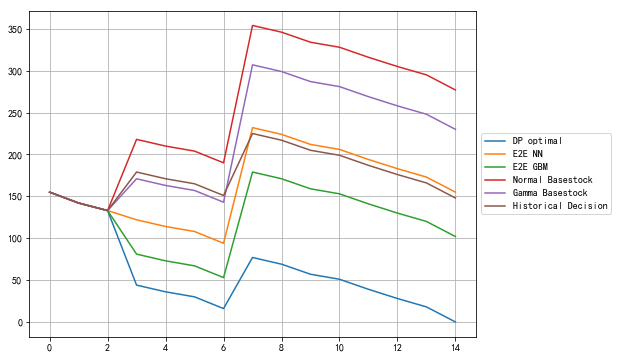

In [817]:
tt = o4g.iloc[96,:]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(tt['OPT_agginv_f'], label = 'DP optimal')
ax1.plot(tt['E2E_NN_agginv_f'], label = 'E2E NN')
ax1.plot(tt['E2E_GBM_agginv_f'], label = 'E2E GBM')
# ax1.plot(tt['EQ_agginv_f'], label = 'Emperical Quantile')
ax1.plot(tt['Normal_agginv_f'], label = 'Normal Basestock')
ax1.plot(tt['Gamma_agginv_f'], label = 'Gamma Basestock')
ax1.plot(tt['Hist_agginv_f'], label = 'Historical Decision')
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax1.grid(True)

In [733]:
co_qtl = df_cost.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
hd_qtl = df_holding.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
bk_qtl = df_back.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)

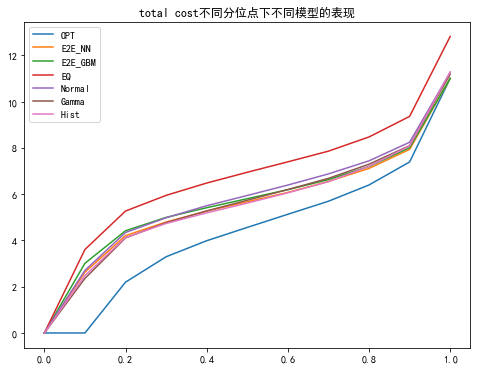

In [734]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(co_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(co_qtl.columns[:-2], loc=0)
ax.set_title('total cost不同分位点下不同模型的表现');

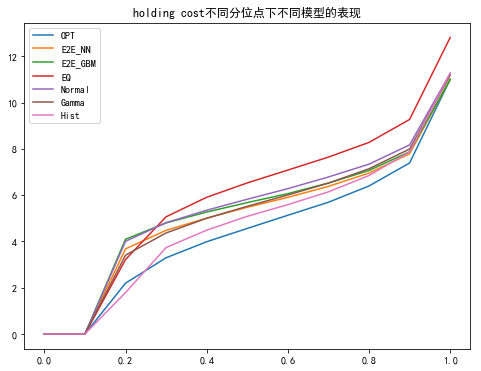

In [735]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(hd_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(hd_qtl.columns[:-2], loc=0)
ax.set_title('holding cost不同分位点下不同模型的表现');

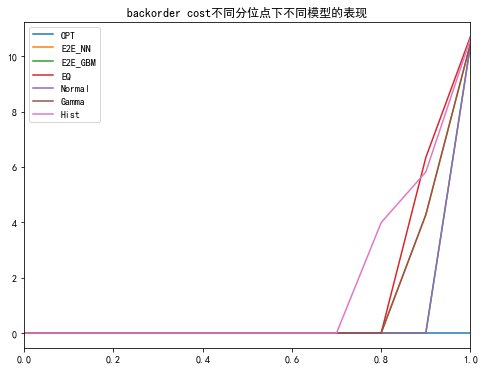

In [736]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(bk_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.set_xlim(0, 1)
ax.legend(bk_qtl.columns[:-2], loc=0)
ax.set_title('backorder cost不同分位点下不同模型的表现');

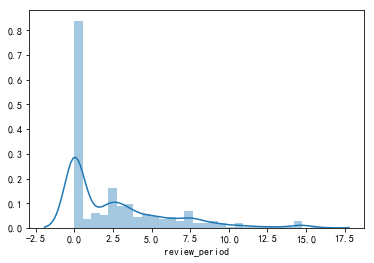

In [737]:
# sns.distplot(np.log(df_cost['Ave_sales']));
sns.distplot(o4.groupby('item_sku_id').review_period.std().fillna(0))

In [ ]:
# py_pp = df_cost
# py_pp['SKU_DC'] = py_pp[['SKU_DC','create_tm']].apply(lambda x: '_'.join([str(i) for i in x]), axis=1)
# py_pp.drop(columns=['create_tm','Ave_sales','Std_sales'], inplace=True)
# py_pp_stack = py_pp.set_index('SKU_DC').stack().rename('method')
# py_pp_stack = pd.DataFrame(py_pp_stack).reset_index()
# taus, solver_vals, solvers, transformed_data = optperfprofpy.calc_perprof(py_pp_stack.iloc[0:770,:], ['SKU_DC'], ['method'], ['level_1'])
# optperfprofpy.draw_simple_pp(taus, solver_vals, solvers)

In [ ]:
# import shap
# # print the JS visualization code to the notebook
# shap.initjs()

In [ ]:
# explainer = shap.TreeExplainer(gbm)
# shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test)

# shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
xx = np.arange(0, 200, 5)
tt_is = X_test_ns.iloc[305:306,:]
yy1, yy2 = [],[]
for i in xx:
#     tt_is['initial_stock'] = i
    tt_ = pd.DataFrame(X_scaler.transform(tt_is), columns=tt_is.columns)

    gbm_pred=gbm.predict(tt_) 
    nn_pred=sess.run(output, feed_dict={x_vlt: tt_[VLT_FEA].values, 
                                  x_sf: tt_[SF_FEA].values, 
                                  x_oth: tt_[MORE_FEA].values, 
                                  x_cat: tt_[CAT_FEA_HOT].values, 
                                  x_is: tt_[IS_FEA].values, 
                                  })
    yy1.append( y_scaler.inverse_transform(gbm_pred.reshape(-1, 1))[0][0] )
    yy2.append( y_scaler.inverse_transform(nn_pred.reshape(-1, 1))[0][0] )

fig, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(xx, yy1, label='GBM');
plt.plot(xx, yy2, label='NN');
plt.plot(xx, 350-xx, label='ideally');

# plt.plot(xx, 330-xx)
plt.xlabel('initial stock')
plt.ylabel('prediction')
plt.legend(prop={'size': 12})

In [ ]:
sess.close()

In [1103]:
import pickle, torch
import importlib
importlib.reload(sys)

with open('../data/1320/dl_supplier_embed.pkl', 'rb') as f:
    supp = pickle.load(f, encoding='bytes')

In [1114]:
supp.shape

torch.Size([3250, 50])

In [1108]:
with open('../data/1320/supp_id.pkl', 'rb') as f:
    supp_dic = pickle.load(f)

In [1113]:
len(supp_dic.major_supp_brevity_code.unique())

3233

In [36]:
with open('../data/1320_feature/df_s2s.pkl', 'rb') as f:
    ox = pickle.load(f)

In [42]:
ox['Enc_X']

0         [array([  33.,   62.,   32.,  137.,   50.,   5...
1         [array([  93.,   36.,   30.,   57.,   73.,   8...
2         [array([  68.,   42.,  155.,  177.,  175.,  11...
3         [array([ 354.,  333.,  563.,  340.,  275.,  12...
4         [array([ 333.,  563.,  340.,  275.,  126.,  30...
5         [array([2094.,  483.,  259.,  192.,  275.,  13...
6         [array([385., 147., 269., 262., 235., 224., 26...
7         [array([100.,  83.,  97., 176., 273., 219., 19...
8         [array([  6.,   7.,  14.,   8.,  17.,   4.,  1...
9         [array([ 15.,   1.,  17.,  13.,  18.,  15.,  1...
10        [array([ 55.,  65.,  92.,  42.,  51.,  12.,  6...
11        [array([ 97., 446.,  40.,  74.,  39.,  44.,  3...
12        [array([446.,  40.,  74.,  39.,  44.,  35., 11...
13        [array([116.,  32.,  53.,  56.,  51.,  37.,  5...
14        [array([12., 15., 21., 21., 53., 36., 47., 43....
15        [array([ 18.,  17.,  12.,   8.,  14.,  19.,  3...
16        [array([161., 512.,  52.,  70.

In [16]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)

In [139]:
# df_sl = df_sl.pct_change(axis='columns').replace(np.inf, 1.0).fillna(0)

,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,...,2018-08-22,2018-08-23,2018-08-24,2018-08-25,2018-08-26,2018-08-27,2018-08-28,2018-08-29,2018-08-30,2018-08-31
row,,,,,,,,,,,,,,,,,,,,,
1001119440#10,0.0,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1001119440#3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1001119440#4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1001119440#5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1001119440#6,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1001120025#10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1001120025#3,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1001120025#4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,-1.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1001120025#5,0.0,-1.000000,0.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [67]:
lw = 40
rw = 30

o0['Enc_X'] = o0.apply(lambda x: [
                    df_sl.loc[x['item_sku_id'], 
                             x['create_tm'].date()-dt.timedelta(days=lw+365):
                                  x['create_tm'].date()-dt.timedelta(days=365)
                            ].values.tolist(),
                    df_sl.loc[x['item_sku_id'], 
                             x['create_tm'].date()-dt.timedelta(days=lw+92):
                                  x['create_tm'].date()-dt.timedelta(days=92)
                             ].values.tolist()
                   ], axis=1)

In [33]:
o0['Enc_y'] = o0.apply(lambda x: [df_sl.loc[x['item_sku_id'], 
                             x['create_tm'].date()-dt.timedelta(days=lw):x['create_tm'].date()
                            ].values.tolist(),
                   ], axis=1)

In [34]:
o0['Dec_X'] = o0.apply(lambda x: [
                    df_sl.loc[x['item_sku_id'], 
                             x['create_tm'].date()-dt.timedelta(days=365):
                                  x['create_tm'].date()-dt.timedelta(days=365-rw)
                            ].values.tolist(),
                    df_sl.loc[x['item_sku_id'], 
                             x['create_tm'].date()-dt.timedelta(days=92):
                                  x['create_tm'].date()-dt.timedelta(days=92-rw)
                             ].values.tolist(),
                   ], axis=1)
o0['Dec_y'] = o0.apply(lambda x: [df_sl.loc[x['item_sku_id'], 
                             x['create_tm'].date():x['create_tm'].date()+dt.timedelta(days=rw)
                            ].values.tolist(),
                   ], axis=1)

In [11]:
import torch

In [25]:
with open('../data/1320_feature/df_s2s.pkl', 'rb') as fp:
    ox = pickle.load(fp)

In [12]:
ts = torch.FloatTensor((ox['Dec_y'].loc[0]))
ts.view(1,31).shape

torch.Size([1, 31])

In [30]:
ox['Enc_X'].apply(lambda x:len(x[0]))

0         91
1         91
2         91
3         91
4         91
5         91
6         91
7         91
8         91
9         91
10        91
11        91
12        91
13        91
14        91
15        91
16        91
17        91
18        91
19        91
20        91
21        91
22        91
23        91
24        91
25        91
26        91
27        91
28        91
29        91
          ..
126825    91
126826    91
126827    91
126828    91
126829    91
126830    91
126831    91
126832    91
126833    91
126834    91
126835    91
126836    91
126837    91
126838    91
126839    91
126840    91
126841    91
126842    91
126843    91
126844    91
126845    91
126846    91
126847    91
126848    91
126849    91
126850    91
126851    91
126852    91
126853    91
126854    91
Name: Enc_X, Length: 126855, dtype: int64

In [14]:
ox['Dec_y']

0         [[164.0, 161.0, 170.0, 188.0, 182.0, 131.0, 11...
1         [[154.0, 167.0, 134.0, 172.0, 161.0, 157.0, 15...
2         [[208.0, 159.0, 197.0, 198.0, 215.0, 155.0, 14...
3         [[200.0, 148.0, 147.0, 148.0, 112.0, 181.0, 11...
4         [[148.0, 147.0, 148.0, 112.0, 181.0, 117.0, 15...
5         [[144.0, 134.0, 127.0, 192.0, 124.0, 165.0, 34...
6         [[340.0, 242.0, 144.0, 154.0, 168.0, 104.0, 13...
7         [[137.0, 149.0, 128.0, 177.0, 183.0, 181.0, 11...
8         [[37.0, 21.0, 41.0, 26.0, 25.0, 24.0, 23.0, 28...
9         [[28.0, 24.0, 0.0, 14.0, 36.0, 22.0, 16.0, 45....
10        [[24.0, 25.0, 39.0, 22.0, 14.0, 21.0, 13.0, 19...
11        [[19.0, 21.0, 31.0, 11.0, 39.0, 19.0, 28.0, 45...
12        [[21.0, 31.0, 11.0, 39.0, 19.0, 28.0, 45.0, 20...
13        [[45.0, 20.0, 40.0, 33.0, 14.0, 22.0, 11.0, 14...
14        [[14.0, 38.0, 14.0, 23.0, 16.0, 33.0, 17.0, 26...
15        [[36.0, 34.0, 33.0, 32.0, 34.0, 33.0, 31.0, 38...
16        [[33.0, 36.0, 47.0, 34.0, 34.0

In [24]:
np.log1p(df_sl.iloc[-9,0:20])

2016-01-01    4.406719
2016-01-02    2.484907
2016-01-03    1.609438
2016-01-04    3.178054
2016-01-05    3.218876
2016-01-06    3.178054
2016-01-07    2.639057
2016-01-08    3.433987
2016-01-09    3.218876
2016-01-10    2.639057
2016-01-11    3.044522
2016-01-12    2.397895
2016-01-13    3.178054
2016-01-14    3.465736
2016-01-15    2.772589
2016-01-16    2.197225
2016-01-17    1.945910
2016-01-18    2.397895
2016-01-19    3.367296
2016-01-20    3.496508
Name: 989897#772, dtype: float64